In [1]:
from collections import namedtuple, OrderedDict
import os

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nengo_learn_assoc_mem.utils import meg_from_spikes, numpy_bytes_to_str
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with h5py.File(os.path.join(data_path, "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    dt = fi["t_range"].attrs["dt"]

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [2]:
experiments = ("base", "higher_thresh", "less_base_inhib", "long_pause", "more_repeats")

In [5]:
new_experiments = ("more_repeats_again", "high_thresh", "higher_thresh_again", "super_high_thresh")

## Compare responses

In [7]:
responses = []
MegResp = namedtuple("MegResp", ["name", "t_pause", "t_present", "spike_response"])

for exp in new_experiments:
    print(exp)
    with h5py.File(os.path.join(data_path, neg_voja_rec_learn, f"{exp}.h5", "r") as fi:
        responses.append(
            MegResp(
                exp,
                fi["w_hist"].attrs["t_pause"],
                fi["w_hist"].attrs["t_present"],
                meg_from_spikes(fi["spike_response"])
            )
        )

more_repeats_again
high_thresh
higher_thresh_again
super_high_thresh


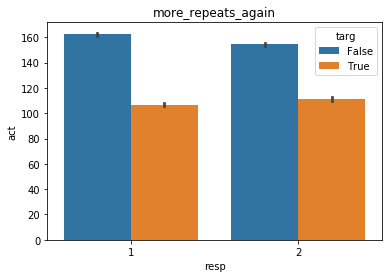

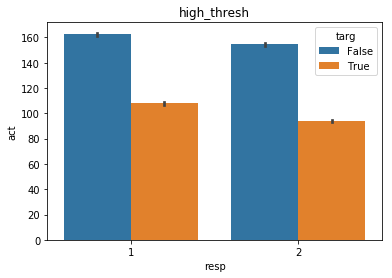

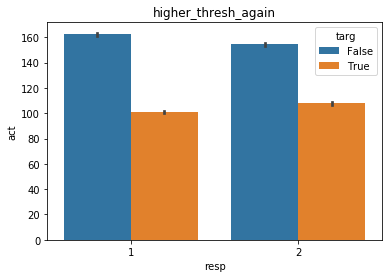

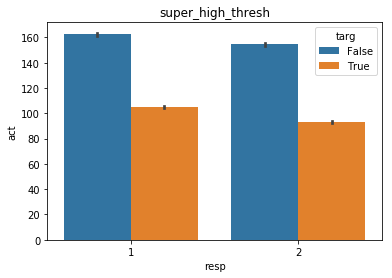

In [8]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

for meg_resp in responses:
    
    df_list = []
    
    t_pause = meg_resp.t_pause
    t_present = meg_resp.t_present
    
    t_each = t_pause + t_present
    td_pause = int(t_pause / dt)
    td_each = int(t_each / dt)
    
    fan1_slc = slice(td_pause, td_each*len(fan1)+td_pause)
    fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2))
    foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1))
    foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2))

    slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                     "fan2": SlcStim(2, True, fan2_slc),
                     "foil1": SlcStim(1, False, foil1_slc),
                     "foil2": SlcStim(2, False, foil2_slc)}

    for key, obj in slc_stim_vecs.items():
        act = meg_resp.spike_response[obj.slc]
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

    act_df = pd.concat(df_list)
    
    plt.figure()
    plt.title(meg_resp.name)
    sns.barplot(x="resp", y="act", hue="targ", data=act_df) 

## Compare Weights

In [3]:
w_hists = {}

for exp in ("base", "higher_thresh", "more_repeats"):
    with h5py.File(f"../data/neg_voja_rec_learn/{exp}.h5", "r") as fi:
        w_hists[exp] = np.array(fi["w_hist"])

In [9]:
for exp in ("base", "higher_thresh", "more_repeats"):
    with h5py.File(f"../data/neg_voja_rec_learn/{exp}.h5", "r") as fi:
        print(exp)
        print(fi["w_hist"].attrs["base_inhib"])

base
-0.002
higher_thresh
-0.002
more_repeats
-0.002


In [4]:
def w_hist_array(w_hist: np.ndarray):
    triu_i  = np.triu_indices(w_hist.shape[1], k=1)
    tril_i = np.tril_indices(w_hist.shape[1], k=-1)
    return np.concatenate((w_hist[:,  triu_i[0], triu_i[1]], w_hist[:, tril_i[0], tril_i[1]]), axis=1)

In [5]:
wh_arrs = {}

for exp, w_h in w_hists.items():
    wh_arrs[exp] = w_hist_array(w_h)

In [10]:
base_inhib = -2e-3

In [12]:
for nm, wh_arr in wh_arrs.items():
    print(nm)
    decr = wh_arr[-1][wh_arr[-1] < base_inhib].shape[0]
    print(f"Number of weights decreased beyond base {base_inhib} by end: {decr}")
    incr = wh_arr[-1][wh_arr[-1] > base_inhib].shape[0]
    print(f"Number of weights increased beyond base {base_inhib} by end: {incr}")
    print(f"Total changed: {decr+incr}\n")

base
Number of weights decreased beyond base -0.002 by end: 1965
Number of weights increased beyond base -0.002 by end: 136
Total changed: 2101

higher_thresh
Number of weights decreased beyond base -0.002 by end: 3403
Number of weights increased beyond base -0.002 by end: 137
Total changed: 3540

more_repeats
Number of weights decreased beyond base -0.002 by end: 3525
Number of weights increased beyond base -0.002 by end: 135
Total changed: 3660



In [14]:
for nm, wh_arr in wh_arrs.items():
    print(f"Mean {nm}: {np.mean(wh_arr[-1][wh_arr[-1] < base_inhib])}")
   

Mean base: -0.0020532648319900376
Mean higher_thresh: -0.002105527795844132
Mean more_repeats: -0.002140657438396124
